# EXPLORATION
# 8. 영화리뷰 텍스트 감성분석하기[프로젝트]

## 8-1. 프로젝트: 네이버 영화리뷰 감성분석 도전하기

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('data/ratings_train.txt')
test_data = pd.read_table('data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

data_loader가 수행해야 하는 동작
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # NAN 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    # 한국어 토크나이저로 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp = tokenizer.morphs(sentence)
        temp = [word for word in temp if not word in stopwords]
        X_train.append(temp)

    X_test = []
    for sentence in test_data['document']:
        temp = tokenizer.morphs(sentence)
        temp = [word for word in temp if not word in stopwords]
        X_test.append(temp)
    
    # 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()    # 리스트로 변환
    counter = Counter(words)    # 단어의 등장 횟수를 가진 리스트
    counter = counter.most_common(num_words-4)  # 내림차순 정렬
                                            # 상위 num_words개 단어 반한
                                            # 앞의 4개는 비어있는 문자열로 대체
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index
                else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])),\
            X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [6]:
word_to_index

{'': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시간': 95,
 '지루': 96,
 '중': 97,
 '재미있': 98,
 '년': 

word_to_index의 index가 3부터 시작하는 것을 확인할 수 있습니다.  
총 4개의 인덱스를 앞에 추가할 것이기 때문에 뒤로 1칸씩만 옮기면 될 것 같습니다.

In [7]:
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

In [8]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
index_to_word

{4: '',
 5: '.',
 6: '영화',
 7: '다',
 8: '고',
 9: '하',
 10: '을',
 11: '보',
 12: '..',
 13: '게',
 14: ',',
 15: '!',
 16: '지',
 17: '있',
 18: '없',
 19: '?',
 20: '좋',
 21: '나',
 22: '었',
 23: '만',
 24: '는데',
 25: '너무',
 26: '봤',
 27: '적',
 28: '안',
 29: '정말',
 30: '로',
 31: '음',
 32: '것',
 33: '아',
 34: '네요',
 35: '재밌',
 36: '어',
 37: '같',
 38: '점',
 39: '지만',
 40: '진짜',
 41: '했',
 42: '에서',
 43: '기',
 44: '네',
 45: '않',
 46: '거',
 47: '았',
 48: '수',
 49: '되',
 50: '면',
 51: 'ㅋㅋ',
 52: '말',
 53: '연기',
 54: '인',
 55: '주',
 56: '내',
 57: '최고',
 58: '~',
 59: '평점',
 60: '이런',
 61: '던',
 62: '어요',
 63: '할',
 64: '왜',
 65: '겠',
 66: '1',
 67: '스토리',
 68: '해',
 69: '습니다',
 70: 'ㅋㅋㅋ',
 71: '...',
 72: '드라마',
 73: '생각',
 74: '아니',
 75: '더',
 76: '그',
 77: '싶',
 78: '사람',
 79: '듯',
 80: '때',
 81: '감동',
 82: '함',
 83: '배우',
 84: '본',
 85: '까지',
 86: '뭐',
 87: '알',
 88: '만들',
 89: '내용',
 90: '볼',
 91: '감독',
 92: '보다',
 93: '라',
 94: '그냥',
 95: '재미',
 96: '시간',
 97: '지루',
 98: '중',
 99: '재미있',
 100:

In [11]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 4 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  67
전체 문장의 0.99755809131817%가 maxlen 설정값 이내에 포함됩니다. 


In [12]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 67)


## 4) 모델 구성 및 validation set 구성

### 모델1

In [13]:
# vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
# word_vector_dim = 67  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(5))
# model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(tf.keras.layers.GlobalMaxPooling1D())
# model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model.summary()

### 모델2

In [14]:
# vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
# word_vector_dim = 67  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(tf.keras.layers.GlobalMaxPooling1D())
# model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


# model.summary()

### 모델3

In [15]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 67  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))    # MaxPooling 레이어 추가
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 67)          670000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          7520      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1

In [16]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 67)
(136182,)


## 5) 모델 훈련 개시

In [17]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # overfitting 방지를 위해 epoch을 많이 낮췄습니다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
266/266 [==============================] - 5s 8ms/step - loss: 0.5799 - accuracy: 0.6636 - val_loss: 0.5097 - val_accuracy: 0.7168
Epoch 2/7
266/266 [==============================] - 2s 6ms/step - loss: 0.4763 - accuracy: 0.7421 - val_loss: 0.5012 - val_accuracy: 0.7242
Epoch 3/7
266/266 [==============================] - 2s 6ms/step - loss: 0.4356 - accuracy: 0.7672 - val_loss: 0.5077 - val_accuracy: 0.7280
Epoch 4/7
266/266 [==============================] - 2s 6ms/step - loss: 0.3875 - accuracy: 0.7939 - val_loss: 0.5297 - val_accuracy: 0.7205
Epoch 5/7
266/266 [==============================] - 2s 6ms/step - loss: 0.3339 - accuracy: 0.8202 - val_loss: 0.5817 - val_accuracy: 0.7167
Epoch 6/7
266/266 [==============================] - 2s 6ms/step - loss: 0.2890 - accuracy: 0.8410 - val_loss: 0.6431 - val_accuracy: 0.7113
Epoch 7/7
266/266 [==============================] - 2s 6ms/step - loss: 0.2590 - accuracy: 0.8523 - val_loss: 0.7143 - val_accuracy: 0.7129


## 6) Loss, Accuracy 그래프 시각화

In [18]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7321 - accuracy: 0.7087
[0.7321262955665588, 0.7087291479110718]


In [19]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


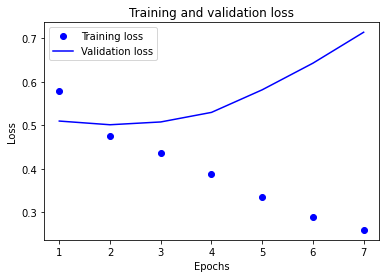

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

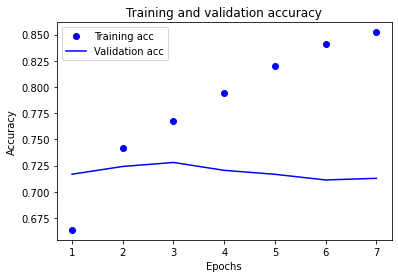

In [21]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [22]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 67)


In [23]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [24]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("재미")

[('김인권', 0.548725426197052),
 ('겉멋', 0.5243067145347595),
 ('자이언트', 0.5020998120307922),
 ('뭣', 0.5010064244270325),
 ('확신', 0.5002673864364624),
 ('갑툭튀', 0.49360281229019165),
 ('붕', 0.4896455705165863),
 ('MC', 0.4894663393497467),
 ('학교', 0.4875684976577759),
 ('놀랄', 0.4806276261806488)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 참고 링크1, 참고 링크2

In [25]:
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['재미']
vector.shape

(100,)

In [26]:
word_vectors.wv.vectors.shape

(302960, 100)

In [27]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv.vectors:
        embedding_matrix[i] = word_vectors.wv.vectors[index_to_word[i]]

/tmp/ipykernel_2258/1177925371.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_to_word[i] in word_vectors.wv.vectors:


In [28]:
embedding_matrix.shape

(10000, 100)

In [29]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 67, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [30]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
266/266 [==============================] - 2s 5ms/step - loss: 0.6234 - accuracy: 0.7254 - val_loss: 0.5025 - val_accuracy: 0.8129
Epoch 2/7
266/266 [==============================] - 1s 4ms/step - loss: 0.4136 - accuracy: 0.8296 - val_loss: 0.3661 - val_accuracy: 0.8406
Epoch 3/7
266/266 [==============================] - 1s 4ms/step - loss: 0.3387 - accuracy: 0.8555 - val_loss: 0.3429 - val_accuracy: 0.8486
Epoch 4/7
266/266 [==============================] - 1s 4ms/step - loss: 0.3080 - accuracy: 0.8708 - val_loss: 0.3343 - val_accuracy: 0.8523
Epoch 5/7
266/266 [==============================] - 1s 4ms/step - loss: 0.2861 - accuracy: 0.8814 - val_loss: 0.3307 - val_accuracy: 0.8550
Epoch 6/7
266/266 [==============================] - 1s 4ms/step - loss: 0.2681 - accuracy: 0.8902 - val_loss: 0.3317 - val_accuracy: 0.8543
Epoch 7/7
266/266 [==============================] - 1s 4ms/step - loss: 0.2516 - accuracy: 0.8988 - val_loss: 0.3357 - val_accuracy: 0.8546


In [31]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3501 - accuracy: 0.8520
[0.3501178026199341, 0.8520251512527466]


- 1번 모델 Accuracy: 0.831 = > 0.851
- 2번 모델 Accuracy: 0.844 => 0.849
- 3번 모델 Accuracy: 0.708 => 0.852

어째서 3번 모델이 다른 모델에 비해서 성능 향상이 큰지는 알 수 없었습니다..